In [ ]:


# # current = os.path.dirname(os.path.abspath("./"))
# # sys.path.append(os.path.join(current,"Diffusion_Models_pytorch_main/"))
# # sys.path[-1]
# # current = os.path.dirname(os.path.abspath("./"))
# sys.path.append(os.path.join(os.getcwd(),"Diffusion_Models_pytorch_main/"))
# sys.path[-1]

'C:\\Users\\midas\\yks\\jupyter_Yonsei\\2023_summer\\DDPM\\Diffusion_Models_pytorch_main/'

# Where does Denoising Diffusion Probabilistic Models focus  from Noise data?

In [1]:
import sys
import os
import gc
import cv2
import math
# import base64
import random
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import torchvision
from torchvision import transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid
# import yks_utils as utils


from torchmetrics import MeanMetric

from IPython.display import display, HTML, clear_output

from dataclasses import dataclass

from DDPM_CAM.grad_cam_ddpm import GradCAM 

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True

C:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
from mnist_unet import UNet
from yks_utils import *
from ddpm import *
# import noising_test
# import ddpm_conditional

In [3]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'red'), (0.25, 'yellow'), (0.5, 'cyan'), (1, 'blue')])


# Set Dataset

In [4]:
from dataclasses import dataclass

@dataclass # init, eq, ne등 메소드가 자동으로 생성됨. 
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "MNIST" #  "MNIST", "Cifar-10", "Cifar-100", "Flowers"
    
    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"

@dataclass
class TrainingConfig:
    TIMESTEPS = 1000 # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32)  # Mnist만 gray scale
    NUM_EPOCHS = 30
    BATCH_SIZE = 128
    LR = 2e-4
    NUM_WORKERS = 0
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device='cpu',
)

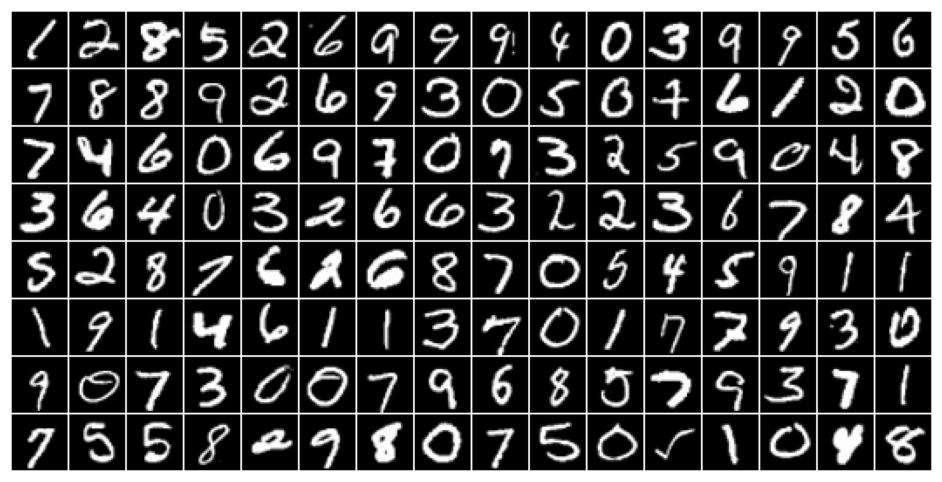

In [5]:
plt.figure(figsize=(12, 6), facecolor='white')

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [6]:
sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")

loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device="cpu",
    )
)

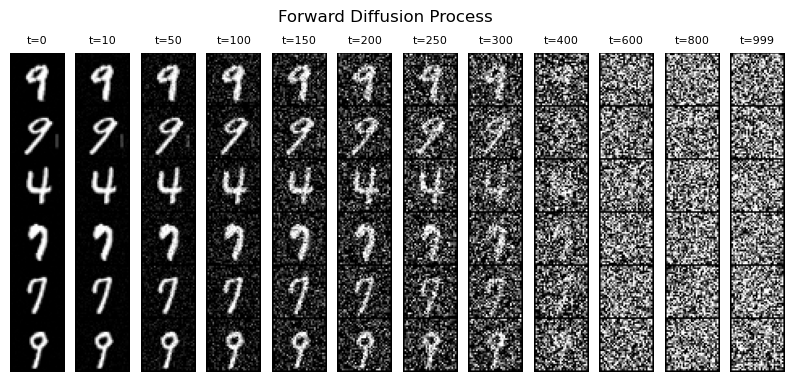

In [7]:
x0s, _ = next(loader)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts    = inverse_transform(xts) / 255.0
    xts    = make_grid(xts, nrow=1, padding=1)
    
    noisy_images.append(xts)

# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.savefig('./Forward_Diffusion_Process.png')
plt.axis("off")
plt.show()

In [8]:
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 512
    BASE_CH_MULT = (1, 2, 4, 8) # 32, 16, 8, 4 
    APPLY_ATTENTION = (False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 2 # 128

In [264]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],  # 1
    output_channels         = TrainingConfig.IMG_SHAPE[0],  # 1
    base_channels           = ModelConfig.BASE_CH,          # 64
    base_channels_multiples = ModelConfig.BASE_CH_MULT,     # (1,2,4,8)
    apply_attention         = ModelConfig.APPLY_ATTENTION,  # (False,False, True, False)
    dropout_rate            = ModelConfig.DROPOUT_RATE,     # 0.1
    time_multiple           = ModelConfig.TIME_EMB_MULT,    # 2 
)
# model = UNet(
#     input_channels          = 1,  # 1
#     output_channels         = 1,  # 1
#     base_channels           = 64,          # 64
#     base_channels_multiples = (1,2,4,8),     # (1,2,4,8)
#     apply_attention         = (False,False, True, False),  # (False,False, True, False)
#     dropout_rate            = 0.1,     # 0.1
#     time_multiple           = 2,    # 2 
# )
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)


sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)
loss_fn = nn.MSELoss()

scaler = amp.GradScaler() # cuda 

model.load_state_dict(torch.load("./Diffusion_model.pth"))

<All keys matched successfully>

In [10]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.image import show_cam_on_image

In [11]:
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

In [12]:
total_epochs = TrainingConfig.NUM_EPOCHS + 1
# log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())
log_dir = "./results/Training/"
generate_video = False
ext = ".mp4" if generate_video else ".png" # png 

In [13]:
# # train
# # loss_min = np.inf
# # loss_list = []
# for epoch in range(1, 20):
#     torch.cuda.empty_cache()
#     gc.collect()
    
#     # Algorithm 1: Training
#     train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

#     if epoch % 5 == 0:
#         save_path = os.path.join(log_dir, f"{epoch}{ext}")
        
#         # Algorithm 2: Sampling
#         reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=32, generate_video=generate_video,
#             save_path=save_path, img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
#         )

#         # clear_output()
#         # checkpoint_dict = {
#         #     "opt": optimizer.state_dict(),
#         #     "scaler": scaler.state_dict(),
#         #     "model": model.state_dict()
#         # }
#         # torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
#         torch.save(model.state_dict(), "./Diffusion_model.pth")
        


In [14]:
# Algorithm 2: Sampling
    
@torch.inference_mode()
def reverse_diffusion_timestep(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, nrow=8, device="cpu", **kwargs):
    reverse_image = []
    x = torch.randn((num_images, *img_shape), device=device)
    
    model.eval()
    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        predicted_noise = model(x, ts)

        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )
        show_ = inverse_transform(x.clone()).type(torch.uint8)
        reverse_image.append(show_)
        grid = torchvision.utils.make_grid(show_, nrow=nrow, pad_value=255.0).to("cpu")
        pil_image = TF.functional.to_pil_image(grid)
        pil_image.save(os.path.join(kwargs['save_path'],f"{time_step}_step.png"))
    print("finishing")
    return reverse_image

In [16]:
log_dir

'./results/sampling/'

In [15]:
# loss_min = np.inf
# loss_list = []
log_dir = "./results/sampling/"

reverse_list = reverse_diffusion_timestep(model,
                  sd,
                  timesteps=TrainingConfig.TIMESTEPS,
                  num_images=1,
                           nrow=1,
                  generate_video=False,
                  save_path=log_dir,
                  img_shape=TrainingConfig.IMG_SHAPE,
                  device=BaseConfig.DEVICE,
)

        


Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

finishing


----------------

In [17]:
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

In [18]:
list(reversed(specific_timesteps))

[999, 800, 600, 400, 300, 250, 200, 150, 100, 50, 10, 0]

In [19]:
num_images = 6
timesteps=TrainingConfig.TIMESTEPS
img_shape=TrainingConfig.IMG_SHAPE
device = BaseConfig.DEVICE
model.eval()
reverse_image = []
x = torch.randn((num_images, *img_shape), device=device) # batch , 
idx = 0
for time_step in tqdm(iterable=reversed(range(0, timesteps)), 
                  total=timesteps-1, dynamic_ncols=False, 
                  desc="Sampling :: ", position=0):
    torch.cuda.empty_cache()
    gc.collect()    
    ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
    z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x) # 마지막은 z \approx 0
    with torch.no_grad():
        predicted_noise = model(x, ts)
    ## sampling
    beta_t                            = get(sd.beta, ts)
    one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
    sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 
    x = (
        one_by_sqrt_alpha_t
        * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
        + torch.sqrt(beta_t) * z
    )
    if time_step==list(reversed(specific_timesteps))[idx]:
        show_ = inverse_transform(x.clone()).type(torch.uint8)
        reverse_image.append(show_)
        idx+=1

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

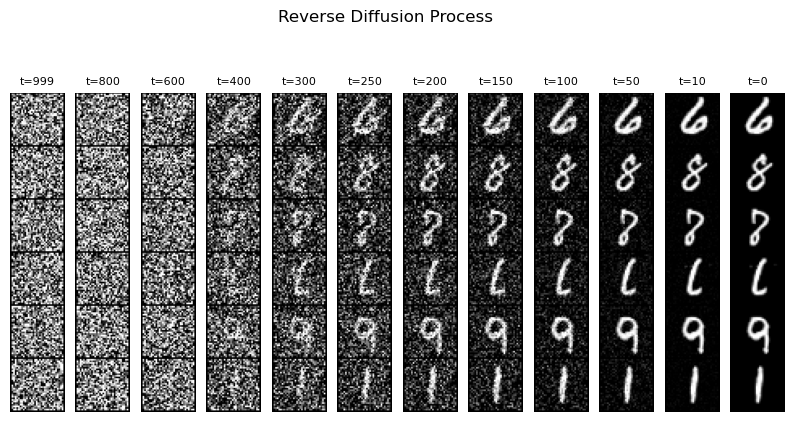

In [20]:
    
_, ax = plt.subplots(1, len(reverse_image), figsize=(10, 6), facecolor='white')

for i, (timestep, denoising_sample) in enumerate(zip(reversed(specific_timesteps), reverse_image)):
    image_ = make_grid(denoising_sample, nrow=1, padding=1).detach().cpu().permute(1,2,0)
    ax[i].imshow(image_)
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Reverse Diffusion Process", y=0.9)
plt.savefig("Reverse_Diffusion_Process.png")
plt.axis("off")
plt.show()    

In [ ]:
# 8이 잘 나와서 8을 따로 저장함 
for idx,i in enumerate(reverse_image):
    cv2.imwrite(f"./results/show/8_{list(reversed(specific_timesteps))[idx]}.png",i[1].detach().cpu().squeeze().numpy())

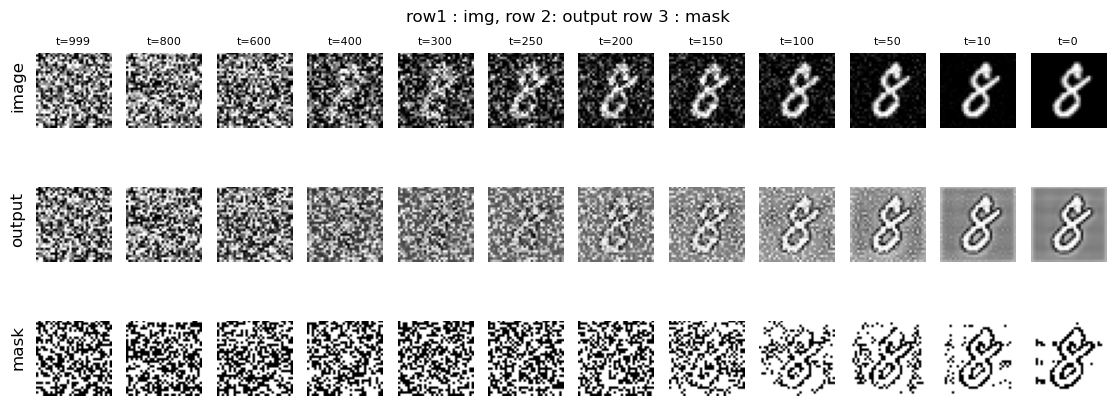

In [53]:
num = 1
f, ax = plt.subplots(3, len(reverse_image), figsize=(11, 5), facecolor='white')
for i, (timestep, denoising_sample) in enumerate(zip(reversed(specific_timesteps), reverse_image)):
    denoising_sample = denoising_sample[num].float()/255.
    # denoising_sample = (denoising_sample-torch.mean(denoising_sample,dim=(1,2,3)))/torch.std(denoising_sample,dim=(1,2,3))
    input_tensor = (denoising_sample-torch.mean(denoising_sample))/torch.std(denoising_sample)
    ts = torch.ones(1, dtype=torch.long) * timestep
    input_tensor = input_tensor.unsqueeze(0) # for batch_size
    
    with torch.no_grad():
        output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
    mask = torch.where(output>0.5,1,0)
    ax[0,i].imshow(denoising_sample.detach().cpu().squeeze(),cmap='gray')
    ax[1,i].imshow(inverse_transform(output).squeeze().detach().cpu(),cmap='gray')
    ax[2,i].imshow(mask.squeeze().detach().cpu(),cmap='gray')
    # ax[0,:].set_title("off")
    # ax[1,i].axis("off")
    # ax[2,i].axis("off")
    
    ax[0,i].set_title(f"t={timestep}", fontsize=8)
    ax[0,i].axis("off")
    ax[1,i].axis("off")
    ax[2,i].axis("off")
    ax[0,i].grid(False)
f.text(-0.01, 0.8, 'image', va='top', rotation='vertical', fontsize=12)
f.text(-0.01, 0.48, 'output', va='center', rotation='vertical', fontsize=12)
f.text(-0.01, 0.18, 'mask', va='bottom', rotation='vertical', fontsize=12)
plt.suptitle("row1 : img, row 2: output row 3 : mask ", y=0.9)
plt.tight_layout()
plt.show()

In [44]:
from mnist_unet import *

In [45]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

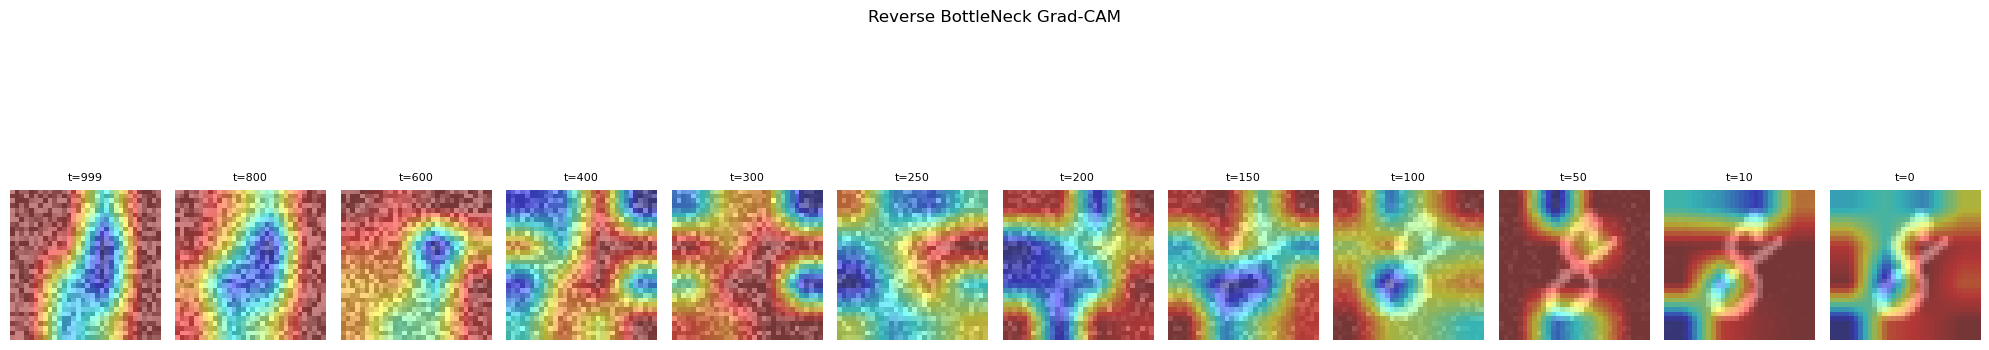

In [62]:
# 단일로 보고 싶을 때 ,

target_layer = list(model.bottleneck_blocks) # set target 
# target_layer = [model.bottleneck_blocks[0],model.bottleneck_blocks[1]]
# bottleneck_target2 = [model.bottleneck_blocks[1]]
# decoder_target    = [model.decoder_blocks[2].resnet2.attention]
# target_layer    = [model.decoder_blocks[2].resnet2.attention]
# final_target      = [model.final]

f,ax = plt.subplots(1,len(reverse_image),figsize=(20,5), facecolor='white')
plt.suptitle("Reverse BottleNeck Grad-CAM")
num=1
for i, (timestep, denoising_sample) in enumerate(zip(reversed(specific_timesteps), reverse_image)):
    denoising_sample = denoising_sample[num].float()/255.
    # denoising_sample = (denoising_sample-torch.mean(denoising_sample,dim=(1,2,3)))/torch.std(denoising_sample,dim=(1,2,3))
    input_tensor = (denoising_sample-torch.mean(denoising_sample))/torch.std(denoising_sample)
    input_tensor = input_tensor.unsqueeze(0) # for batch_size
    ts = torch.ones(1, dtype=torch.long) * timestep
    
    with torch.no_grad():
        output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
    mask = torch.where(output>0.5,1,0)
    targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
    
    
    cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
    grayscale_cams = cam(input_tensor=input_tensor,
                     noise =ts,
                     targets = targets).squeeze()
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].imshow(heatmap,alpha= 0.7,cmap=cmap)
    ax[i].imshow(denoising_sample.detach().cpu().squeeze(),alpha=0.3,cmap='gray')
    ax[i].axis(False)
# plt.savefig("./GRAD_CAM_5_layer.png")
# plt.colorbar(cmap=cmap)
# f.colorbar(dumy,cmap=cmap)
# plt.savefig("./Bottle_neck.png")
plt.tight_layout()
plt.show()    

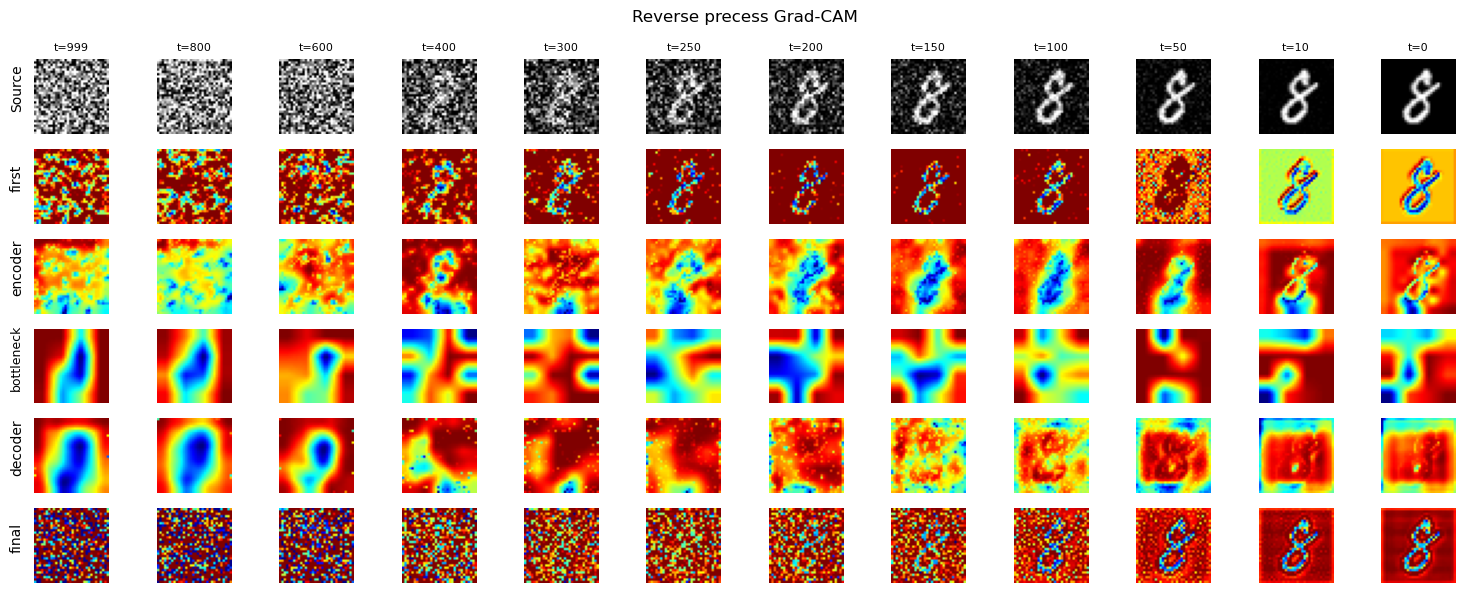

In [63]:
# for overall process 
first_target = [model.first]
encoder_target = list(model.encoder_blocks)
bottleneck_target = list(model.bottleneck_blocks)
# bottleneck_target = [model.bottleneck_blocks[0]]
decoder_target = list(model.decoder_blocks)
final_target = [model.final]

target_list = [first_target,encoder_target,bottleneck_target,decoder_target,final_target]
target_name = ["first","encoder","bottleneck","decoder","final"]

########
model.eval()
f,ax = plt.subplots(len(target_list)+1,len(reverse_image),figsize=(15,6), facecolor='white')
plt.suptitle("Reverse precess Grad-CAM")

for i, (timestep, denoising_sample) in enumerate(zip(reversed(specific_timesteps), reverse_image)):
    denoising_sample = denoising_sample[num].float()/255.
    # denoising_sample = (denoising_sample-torch.mean(denoising_sample,dim=(1,2,3)))/torch.std(denoising_sample,dim=(1,2,3))
    input_tensor = (denoising_sample-torch.mean(denoising_sample))/torch.std(denoising_sample)
    input_tensor = input_tensor.unsqueeze(0) # for batch_size
    ts = torch.ones(1, dtype=torch.long) * timestep
    ##########
    ######
    ax[0,i].imshow(denoising_sample.detach().cpu().squeeze(),cmap='gray')
    ax[0,i].axis(False)
    for j,(target_layer,name) in enumerate(zip(target_list,target_name)):
        cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
        grayscale_cams = cam(input_tensor=input_tensor,
                         noise =ts,
                         targets = targets).squeeze()
        heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
        # ax[0,j].set_title(name)
        ax[0,i].set_title(f"t={timestep}", fontsize=8)
        with torch.no_grad():
            output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
        mask = torch.where(output>0.5,1,0)
        targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
        ax[j+1,i].axis(False)
        # ax[j,i].imshow(denoising_sample.detach().cpu().squeeze(),alpha=0.,cmap='gray')
        ax[j+1,i].imshow(heatmap,alpha= 1,cmap=cmap)
f.text(0.01, 0.85, "Source", va='center', rotation='vertical', fontsize=10)
f.text(0.01, 0.7, target_name[0], va='center', rotation='vertical', fontsize=10)
f.text(0.01, 0.55,target_name[1], va='center', rotation='vertical', fontsize=10)
f.text(0.01, 0.4,target_name[2], va='center', rotation='vertical', fontsize=9)
f.text(0.01, 0.25,target_name[3], va='center', rotation='vertical', fontsize=10)
f.text(0.01, 0.1,target_name[4], va='center', rotation='vertical', fontsize=10)
# plt.colorbar(cmap=cmap)
# f.colorbar(dumy,cmap=cmap)
plt.tight_layout()
plt.savefig(f"./Overall_reverse{num}.png",dpi=200)
plt.show()    

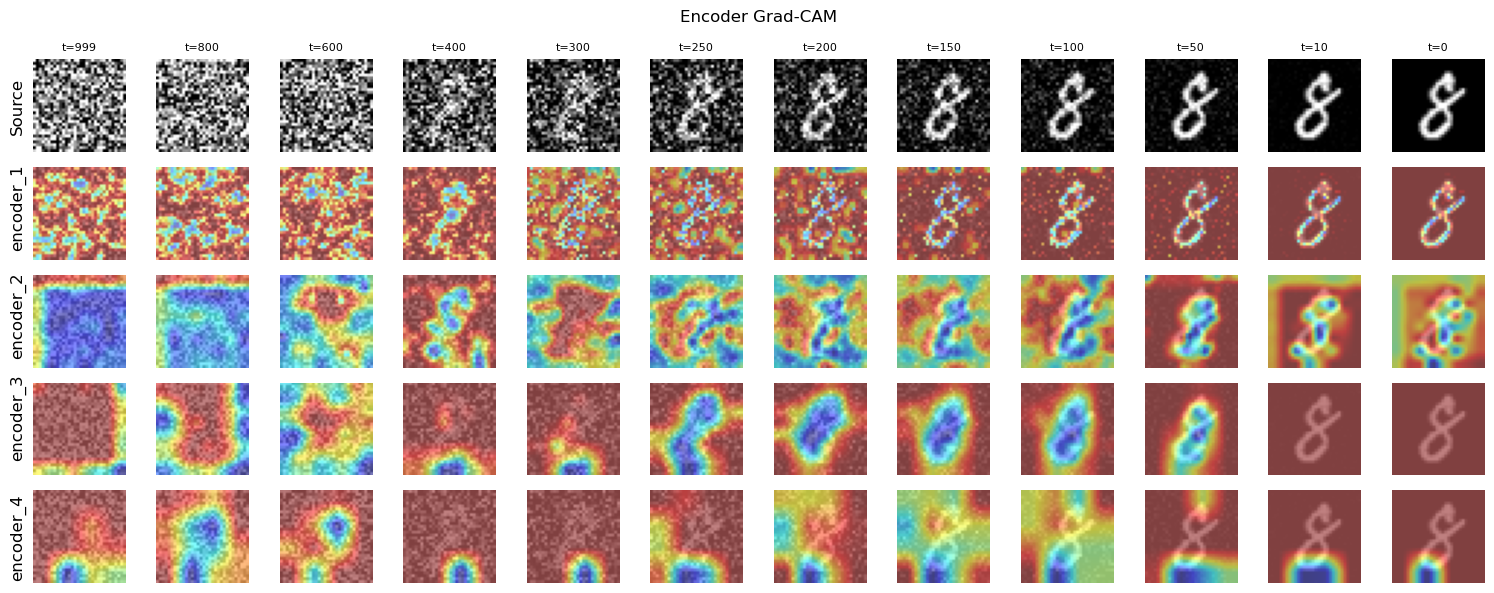

In [64]:
# for overall process 
target_list = [model.encoder_blocks[2*i:2*(i+1)] for i in range(4)]

f,ax = plt.subplots(len(target_list)+1,len(reverse_image),figsize=(15,6), facecolor='white')
plt.suptitle("Encoder Grad-CAM")

for i, (timestep, denoising_sample) in enumerate(zip(reversed(specific_timesteps), reverse_image)):
    denoising_sample = denoising_sample[num].float()/255.
    # denoising_sample = (denoising_sample-torch.mean(denoising_sample,dim=(1,2,3)))/torch.std(denoising_sample,dim=(1,2,3))
    input_tensor = (denoising_sample-torch.mean(denoising_sample))/torch.std(denoising_sample)
    input_tensor = input_tensor.unsqueeze(0) # for batch_size
    ts = torch.ones(1, dtype=torch.long) * timestep
    ##########
    ######
    ax[0,i].imshow(denoising_sample.detach().cpu().squeeze(),cmap='gray')
    ax[0,i].axis(False)
    for j,(target_layer,name) in enumerate(zip(target_list,target_name)):
        cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
        grayscale_cams = cam(input_tensor=input_tensor,
                         noise =ts,
                         targets = targets).squeeze()
        heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
        # ax[0,j].set_title(name)
        ax[0,i].set_title(f"t={timestep}", fontsize=8)
        with torch.no_grad():
            output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
        mask = torch.where(output>0.5,1,0)
        targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
        ax[j+1,i].axis(False)
        ax[j+1,i].imshow(denoising_sample.detach().cpu().squeeze(),alpha=0.5,cmap='gray')
        ax[j+1,i].imshow(heatmap,alpha= 0.5,cmap=cmap)
f.text(0.001, 0.82, "Source", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.65,  "encoder_1", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.47, "encoder_2", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.3,  "encoder_3", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.1, "encoder_4", va='center', rotation='vertical', fontsize=12)
# f.text(0.01, 0.1,  "encoder_", va='center', rotation='vertical', fontsize=10)
# plt.colorbar(cmap=cmap)
# f.colorbar(dumy,cmap=cmap)
plt.tight_layout()
plt.savefig(f"./encoder_block_cam{num}.png",dpi=200)
plt.show()    

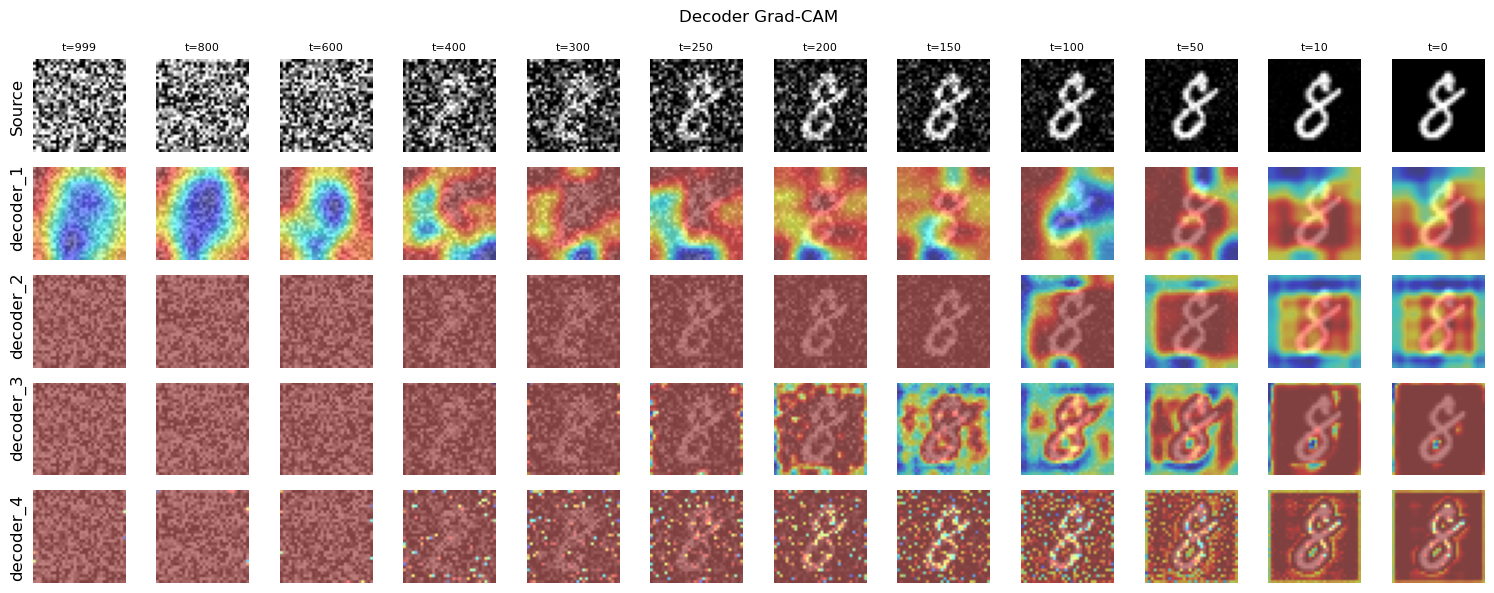

In [65]:
# for overall process 
target_list = [model.decoder_blocks[2*i:2*(i+1)] for i in range(4)]

f,ax = plt.subplots(len(target_list)+1,len(reverse_image),figsize=(15,6), facecolor='white')
plt.suptitle("Decoder Grad-CAM")

for i, (timestep, denoising_sample) in enumerate(zip(reversed(specific_timesteps), reverse_image)):
    denoising_sample = denoising_sample[num].float()/255.
    # denoising_sample = (denoising_sample-torch.mean(denoising_sample,dim=(1,2,3)))/torch.std(denoising_sample,dim=(1,2,3))
    input_tensor = (denoising_sample-torch.mean(denoising_sample))/torch.std(denoising_sample)
    input_tensor = input_tensor.unsqueeze(0) # for batch_size
    ts = torch.ones(1, dtype=torch.long) * timestep
    ##########
    ######
    ax[0,i].imshow(denoising_sample.detach().cpu().squeeze(),cmap='gray')
    ax[0,i].axis(False)
    for j,(target_layer,name) in enumerate(zip(target_list,target_name)):
        cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
        grayscale_cams = cam(input_tensor=input_tensor,
                         noise =ts,
                         targets = targets).squeeze()
        heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
        # ax[0,j].set_title(name)
        ax[0,i].set_title(f"t={timestep}", fontsize=8)
        with torch.no_grad():
            output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
        mask = torch.where(output>0.5,1,0)
        targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
        ax[j+1,i].axis(False)
        ax[j+1,i].imshow(denoising_sample.detach().cpu().squeeze(),alpha=0.5,cmap='gray')
        ax[j+1,i].imshow(heatmap,alpha= 0.5,cmap=cmap)
f.text(0.001, 0.82, "Source", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.65,  "decoder_1", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.47, "decoder_2", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.3,  "decoder_3", va='center', rotation='vertical', fontsize=12)
f.text(0.001, 0.1, "decoder_4", va='center', rotation='vertical', fontsize=12)
# f.text(0.01, 0.1,  "encoder_", va='center', rotation='vertical', fontsize=10)
# plt.colorbar(cmap=cmap)
# f.colorbar(dumy,cmap=cmap)
plt.tight_layout()
plt.savefig(f"./decoder_cam{num}.png",dpi=200)
plt.show()    

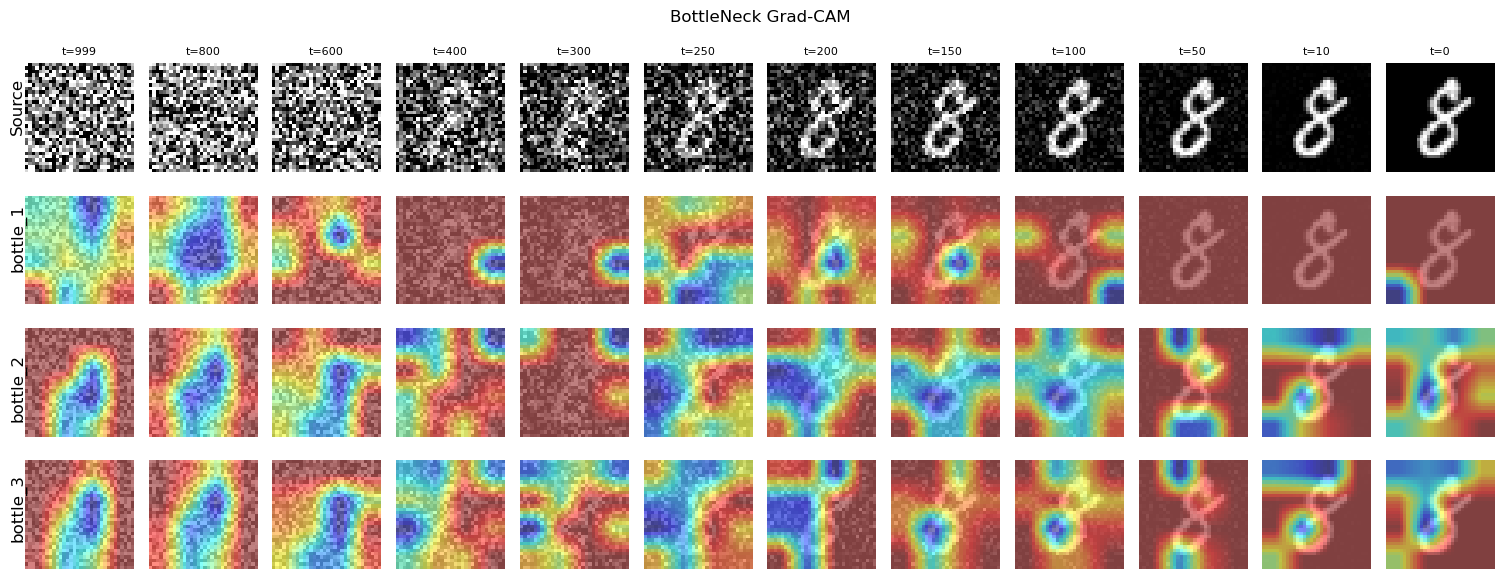

In [66]:
# for overall process 
# target_list = [botle]
target_list = [[model.bottleneck_blocks[i]] for i in range(3)]
# target_list.append(model.bottleneck_blocks)

f,ax = plt.subplots(len(target_list)+1,len(reverse_image),figsize=(15,6), facecolor='white')
plt.suptitle("BottleNeck Grad-CAM")

for i, (timestep, denoising_sample) in enumerate(zip(reversed(specific_timesteps), reverse_image)):
    denoising_sample = denoising_sample[num].float()/255.
    # denoising_sample = (denoising_sample-torch.mean(denoising_sample,dim=(1,2,3)))/torch.std(denoising_sample,dim=(1,2,3))
    input_tensor = (denoising_sample-torch.mean(denoising_sample))/torch.std(denoising_sample)
    input_tensor = input_tensor.unsqueeze(0) # for batch_size
    ts = torch.ones(1, dtype=torch.long) * timestep
    ##########
    ######
    ax[0,i].imshow(denoising_sample.detach().cpu().squeeze(),cmap='gray')
    ax[0,i].axis(False)
    for j,(target_layer,name) in enumerate(zip(target_list,target_name)):
        cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
        grayscale_cams = cam(input_tensor=input_tensor,
                         noise =ts,
                         targets = targets).squeeze()
        heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
        # ax[0,j].set_title(name)
        ax[0,i].set_title(f"t={timestep}", fontsize=8)
        with torch.no_grad():
            output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
        mask = torch.where(output>0.5,1,0)
        targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
        ax[j+1,i].axis(False)
        ax[j+1,i].imshow(denoising_sample.detach().cpu().squeeze(),alpha=0.5,cmap='gray')
        ax[j+1,i].imshow(heatmap,alpha= 0.5,cmap=cmap)
f.text(0.0001, 0.82, "Source", va='center', rotation='vertical', fontsize=12)
f.text(0.0001, 0.6,  "bottle_1", va='center', rotation='vertical', fontsize=12)
f.text(0.0001, 0.35, "bottle_2", va='center', rotation='vertical', fontsize=12)
f.text(0.0001, 0.15,  "bottle_3", va='center', rotation='vertical', fontsize=12)
# f.text(0.001, 0.1, "total_", va='center', rotation='vertical', fontsize=12)
# f.text(0.01, 0.1,  "encoder_", va='center', rotation='vertical', fontsize=10)
# plt.colorbar(cmap=cmap)
# f.colorbar(dumy,cmap=cmap)
plt.tight_layout()
plt.savefig(f"./BottleNeck{num}.png",dpi=200)
plt.show()    

# T=100일 때의 grad-cam의 input -> decoder sequence 결과를 확인해보자.  

In [421]:
model.time_embeddings.time_blocks[0]

Embedding(1000, 64)

In [ ]:
SinusoidalPositionEmbeddings

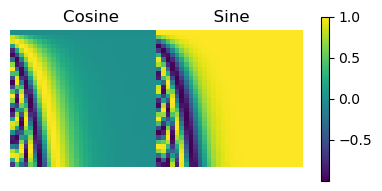

In [472]:
plt.figure(figsize=(4,2))
plt.imshow(model.time_embeddings.time_blocks[0].weight[:30,:].detach().cpu())
plt.axis(False)
plt.title("Cosine                  Sine")

plt.colorbar()
plt.tight_layout()
plt.savefig("./SinusoidalPositionEmbeddings.png",dpi=200)
plt.show()


In [466]:
data = torch.ones(100,dtype=torch.long,device='cuda')
for i in range(20):
    data[i]*=i
    

In [402]:
model.time_embeddings(torch.ones(5,dtype=torch.long).to('cuda')).shape

torch.Size([5, 128])

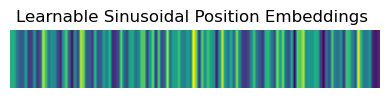

In [477]:
plt.figure(figsize=(4,1))
plt.imshow(model.time_embeddings(torch.ones(20,dtype=torch.long).to('cuda')).detach().cpu())
plt.axis(False)
plt.tight_layout()
plt.title("Learnable Sinusoidal Position Embeddings ")
plt.savefig("./SinusoidalPositionEmbeddings_Linear.png",dpi=200)
# plt.colorbar()

In [389]:
attention = model.encoder_blocks[4].resnet2.attention.mhsa

In [390]:
Q  = attention.in_proj_weight[:256,:]
K = attention.in_proj_weight[256:256*2,:]
V = attention.in_proj_weight[256*2:,:]
Q.shape, K.shape, V.shape

(torch.Size([256, 256]), torch.Size([256, 256]), torch.Size([256, 256]))

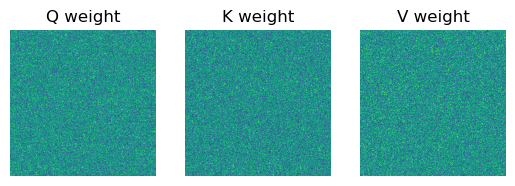

In [393]:
plt.subplot(131)
plt.axis(False)
plt.title("Q weight")
plt.imshow(Q.detach().cpu())
plt.subplot(132)
plt.axis(False)
plt.title("K weight")
plt.imshow(K.detach().cpu())
plt.subplot(133)
plt.axis(False)
plt.title("V weight")
plt.imshow(V.detach().cpu())
plt.show()

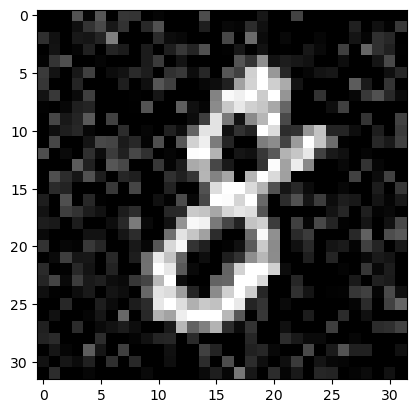

In [129]:
img = cv2.imread("./results/show/8_100.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.show()

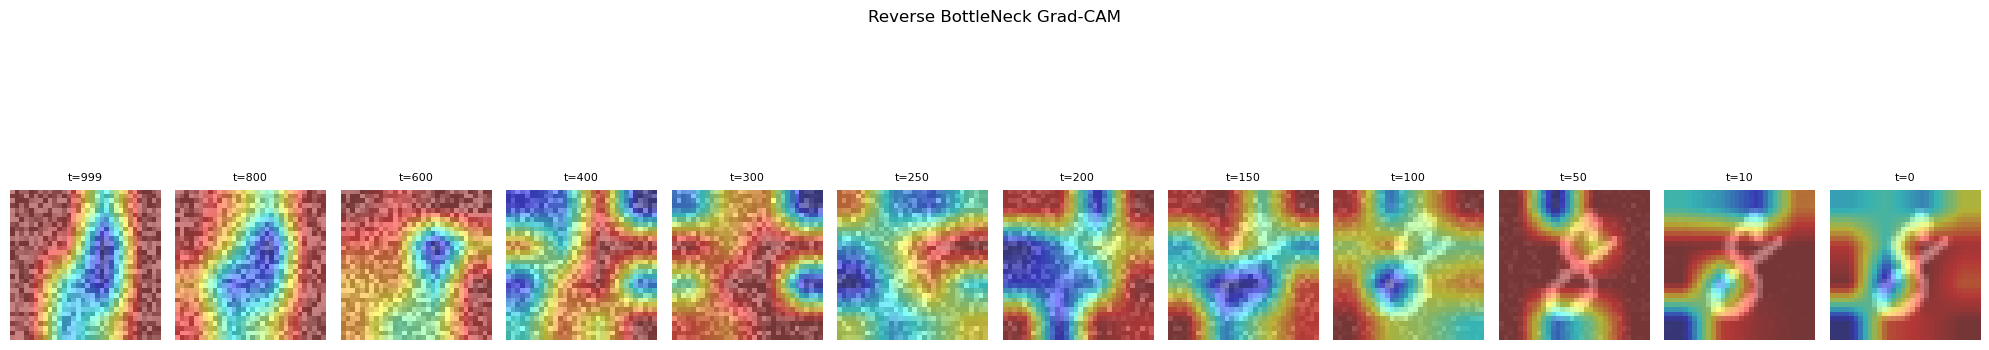

In [171]:
# # 단일로 보고 싶을 때 ,

# target_layer = list(model.bottleneck_blocks) # set target 

# f,ax = plt.subplots(1,len(reverse_image),figsize=(20,5), facecolor='white')
# plt.suptitle("Reverse BottleNeck Grad-CAM")
# # num=1
# for j,(target_layer,name) in enumerate(zip(target_list,target_name)):
#     cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
#     grayscale_cams = cam(input_tensor=input_tensor,
#                      noise =ts,
#                      targets = targets).squeeze()
#     heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
#     # ax[0,j].set_title(name)
#     ax[0,i].set_title(f"t={timestep}", fontsize=8)
#     with torch.no_grad():
#         output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
#     mask = torch.where(output>0.5,1,0)
#     targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
#     ax[j+1,i].axis(False)
#     ax[j+1,i].imshow(denoising_sample.detach().cpu().squeeze(),alpha=0.5,cmap='gray')
#     ts = torch.ones(1, dtype=torch.long) * timestep
    
#     with torch.no_grad():
#         output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
#     mask = torch.where(output>0.5,1,0)
#     targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
    
    
#     cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
#     grayscale_cams = cam(input_tensor=input_tensor,
#                      noise =ts,
#                      targets = targets).squeeze()
#     heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
#     ax[i].set_title(f"t={timestep}", fontsize=8)
#     ax[i].imshow(heatmap,alpha= 0.7,cmap=cmap)
#     ax[i].imshow(denoising_sample.detach().cpu().squeeze(),alpha=0.3,cmap='gray')
#     ax[i].axis(False)
# # plt.savefig("./GRAD_CAM_5_layer.png")
# # plt.colorbar(cmap=cmap)
# # f.colorbar(dumy,cmap=cmap)
# # plt.savefig("./Bottle_neck.png")
# plt.tight_layout()
# plt.show()    

# for one Image

In [368]:
encoder_target    = [model.encoder_blocks[4].resnet2.attention]
bottleneck_target = [model.bottleneck_blocks[1].attention]
decoder_target1    = [model.decoder_blocks[2].resnet1.attention]
decoder_target2 = [model.decoder_blocks[2].resnet2.attention]
target_list = [encoder_target,bottleneck_target,decoder_target1,decoder_target2]
target_name = ["encoder_attention","bottleneck_attention","decoder_attention_1","decoder_attention_2"]
targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]

step_list = [999 , 800, 600,400,300,250,200, 100, 50, 10, 0]
filenames = []
# img = cv2.imread(f"./results/sampling/{step}_step.png")
for step in step_list:
    img = cv2.imread(f"./results/show/8_{step}.png")
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


    img = img.astype(np.float32)/255.
    input_tensor = preprocess_image(img, mean = 0.5,std =0.224)
    ts = torch.ones(1, dtype=torch.long) * step
    model.eval()
# target_layers = [model.first,
                 # model.bottleneck_blocks[0] # module을 정확하게 넣어야함
# output = F.sigmoid(model(input_tensor.cuda(),ts.cuda()))
# targets = [SemanticSegmentationTarget(0,mask.cpu().numpy())]
# first_target      = [model.first]

# final_target      = [model.final]
    f,ax = plt.subplots(1,len(target_list),figsize=(12,4))
    plt.suptitle(f"When layer is {step}, Attention Layer Grad-CAM")
    # ax[0].set_title("img")
    for idx,(target_layer,name) in enumerate(zip(target_list,target_name)):
        with torch.no_grad():
            output = F.sigmoid(model(input_tensor.cuda(),ts.cuda())) # [-1~1] -> [0~1]
            mask = torch.where(output>0.5,1,0)

        cam = GradCAM(model = model,target_layers=target_layer,use_cuda=True)
        grayscale_cams = cam(input_tensor=input_tensor,
                         noise =ts,
                         targets = targets).squeeze()
        heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)
        ax[idx].set_title(name,fontsize=12)
        ax[idx].imshow(heatmap,alpha= 0.7,cmap=cmap)
        ax[idx].imshow(img,alpha=0.3,cmap='gray')
        ax[idx].axis(False)
    filename = f"./results/gif/when TimeStep is {step}, attention_layer.png"
    filenames.append(filename)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    
# plt.savefig("./GRAD_CAM_5_layer.png")
# plt.colorbar(cmap=cmap)
# f.colorbar(dumy,cmap=cmap)

# plt.show()

In [369]:
def generate_gif(filenames:list ,gif_name:str,removing=True,
                 gif_config = {
    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
    'duration': 0.5 ## 다음 화면으로 넘어가는 시간
    }):
    print("creating gif\n")
    print(gif_name)
    with imageio.get_writer(gif_name, mode='I',**gif_config) as writer:
        for filename in tqdm(filenames,leave=False):
            image = imageio.v2.imread(filename)
            writer.append_data(image)

    print("Finish creating\n")

    if removing:
        Removing(filenames)
    return


In [378]:
import imageio
from IPython.display import clear_output
from IPython.display import HTML
from IPython.display import Image
from IPython.display import Video

generate_gif(filenames, "./results/gif/attention.gif",False,
            gif_config={
                    'loop':0, ## 0으로 세팅하면 무한 반복, 3으로 설정하면 3번 반복
                    'duration':300 ## 다음 화면으로 넘어가는 시간
            })

creating gif

./results/gif/attention.gif


  0%|          | 0/11 [00:00<?, ?it/s]

Finish creating



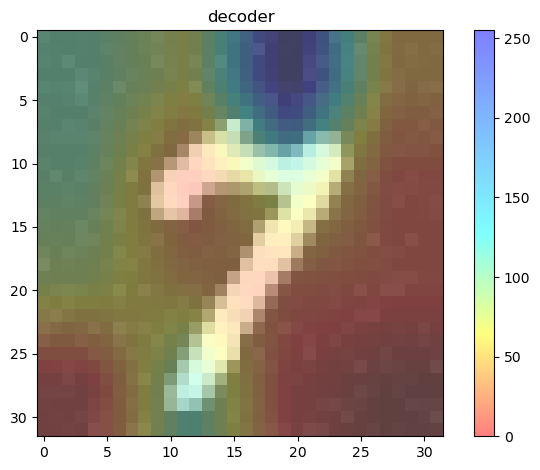

In [354]:
decoder_target    = [model.bottleneck_blocks[0]]

cam = GradCAM(model = model,
             target_layers=decoder_target,
             use_cuda=True)

# targets = None

grayscale_cams = cam(input_tensor=input_tensor,
                     noise =ts,
                     targets = targets).squeeze()
heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)

plt.title("decoder")
plt.imshow(heatmap,alpha= 0.5,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.imshow(img,alpha=0.5,cmap='gray')
plt.tight_layout()
plt.show()

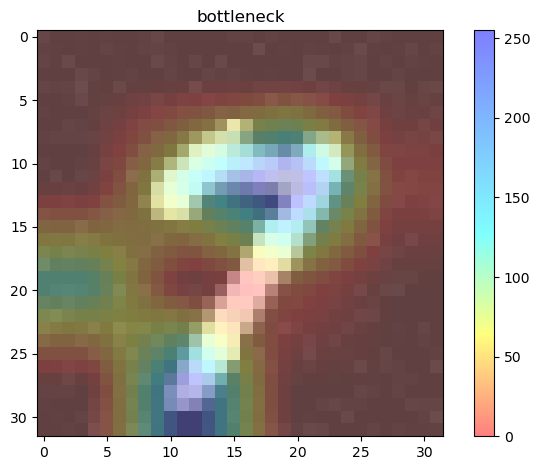

In [104]:
plt.title("bottleneck")
plt.imshow(heatmap,alpha= 0.5,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.imshow(img,alpha=0.5,cmap='gray')
plt.tight_layout()
plt.show()

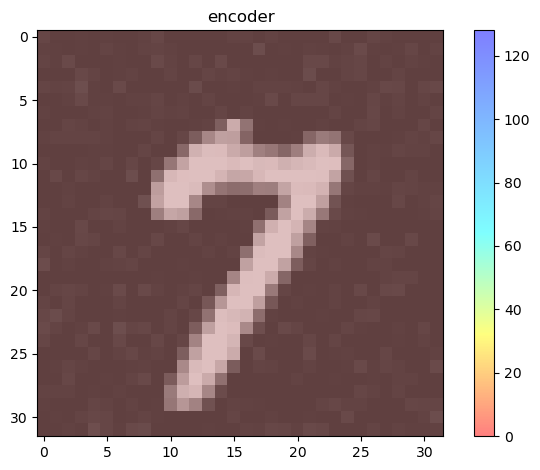

In [161]:
encoder    = [model.encoder_blocks[4].resnet2.attention]

cam = GradCAM(model = model,
             target_layers=encoder,
             use_cuda=True)

# targets = None

grayscale_cams = cam(input_tensor=input_tensor,
                     noise =ts,
                     targets = targets).squeeze()
heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cams), cv2.COLORMAP_JET)

plt.title("encoder")
plt.imshow(heatmap,alpha= 0.5,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.imshow(img,alpha=0.5,cmap='gray')
plt.tight_layout()
plt.show()

In [74]:
from mnist_unet import AttentionBlock
# model.load_state_dict(torch.load("./Diffusion_model.pth"))
attention_block = {}

for key,value in model.named_children(): # key: string , value: module
    for i in value.modules():  # modules return all modules corresponding value
        if isinstance(i,AttentionBlock): # if model have a AttentionBlock
            attention_block.update({key:i}) # update 

In [76]:
attention_block['encoder_blocks']

AttentionBlock(
  (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
  (mhsa): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (ff_self): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [37]:
# attention_block

In [46]:
for i,value in model.named_children():
    print(i)

time_embeddings
first
encoder_blocks
bottleneck_blocks
decoder_blocks
final


In [38]:
class attention_hook(nn.Module):
    def __init__(self,model , ):
        # names = []
        # for name,module in self.unet.named_children():
        #     names.append(name)
        self.time_embeddings = model.time_embeddings
        self.first           = model.first
        self.encoder         = model.encoder_blocks
        self.bottleneck      = model.bottleneck_blocks
        self.decoder         = model.decoder_blocks
        self.final           = model.final
        
        
    
    
    def get_encoder_activation(self,):
        return
    def get_bottleneck_activation(self,):
        return
    def get_decoder_activation(self,):
        return 
    
    def get_encoder_weight(self,):
        return
    def get_bottleneck_weight(self,):
        return
    def get_decoder_weight(self,):
        return

SyntaxError: unexpected EOF while parsing (2039837115.py, line 1)

In [131]:
key_list = list(attention_block.keys())
key_list

['encoder_blocks', 'bottleneck_blocks', 'decoder_blocks']

In [132]:
encoder_attention    = attention_block[key_list[0]].mhsa
bottleneck_attention = attention_block[key_list[1]].mhsa
decoder_attention    = attention_block[key_list[1]].mhsa


In [134]:
encoder_attention.in_proj_weight.shape

torch.Size([768, 256])

In [135]:
encoder_split = encoder_attention.in_proj_weight.shape[0]//3
q_weight = encoder_attention.in_proj_weight[:encoder_split, :]
k_weight = encoder_attention.in_proj_weight[encoder_split:encoder_split*2, :]
v_weight = encoder_attention.in_proj_weight[encoder_split*2:, :]

In [ ]:
data ,labels = next(iter(loader))
t = torch.

In [141]:
model.time_embeddings()

UNet(
  (time_embeddings): SinusoidalPositionEmbeddings(
    (time_blocks): Sequential(
      (0): Embedding(1000, 64)
      (1): Linear(in_features=64, out_features=128, bias=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (first): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (encoder_blocks): Sequential(
    (0): DoubleBlock(
      (resnet1): ResnetBlock(
        (act_fn): SiLU()
        (normlize_1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (dense_1): Linear(in_features=128, out_features=64, bias=True)
        (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
        (dropout): Dropout2d(p=0.1, inplace=False)
        (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (match_input): Identity()
        (attention): Identity()
      )
      (resnet2): ResnetBlock(
        (act_fn): SiLU()
  

In [ ]:
attention_value ,attention_weight = encoder_attention()

In [104]:
encoder_weight

torch.Size([768, 256])

In [ ]:
# data, label = next(iter(train_loader))
# # time_step = 999
# # num_images = 5
# device = config.device
# time_step =999
# diffusion  =ddpm.Diffusion(img_size=config.image_size,device = config.device)
# ts = torch.ones(config.batch_size, dtype=torch.long, device=device) * time_step
# x = torch.randn((config.batch_size, 1, config.image_size,config.image_size)).to(device)
# alpha = diffusion.alpha[ts][:, None, None, None]
# alpha_hat = diffusion.alpha_hat[ts][:, None, None, None]
# beta = diffusion.beta[ts][:, None, None, None]
# noise = torch.zeros_like(x)
# #sampling
# # predicted_noise = model(x,ts)
# # x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

---------

In [ ]:
model.load_state_dict(torch.load("./model.pth"))

<All keys matched successfully>

In [37]:
data, label = next(iter(train_loader))
# time_step = 999a
# num_images = 5
device = config.device
time_step =999
diffusion  =ddpm.Diffusion(img_size=config.image_size,device = config.device)
ts = torch.ones(config.batch_size, dtype=torch.long, device=device) * time_step
x = torch.randn((config.batch_size, 1, config.image_size,config.image_size)).to(device)
alpha = diffusion.alpha[ts][:, None, None, None]
alpha_hat = diffusion.alpha_hat[ts][:, None, None, None]
beta = diffusion.beta[ts][:, None, None, None]
noise = torch.zeros_like(x)
#sampling
# predicted_noise = model(x,ts)
# x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

NameError: name 'ddpm' is not defined

In [13]:
x_t, noise = diffusion.noise_images(data.to(device), ts)


In [14]:
# predicted_noise = model(x_t,ts)
# loss = F.mse_loss(noise, predicted_noise)


# Attention score result 

In [15]:
# predicted_noise = model(x,ts)

In [17]:
# encoder = nn.Sequential(*list(model.encoder_blocks.children()))

In [18]:
# encoder    = model.encoder_blocks
# bottleneck = model.bottleneck_blocks
# decoder    = model.decoder_blocks
# encoder_layer=decoder_layer=6
# bottle_layer=0
# first_encoder = encoder[:encoder_layer]
# second_encoder = encoder[encoder_layer:]
# first_bottleneck = bottleneck[:bottle_layer]
# second_bottleneck = bottleneck[bottle_layer:]
# first_decoder = decoder[:decoder_layer]
# second_decoder = decoder[decoder_layer:]

In [19]:
time_emb= model.time_embeddings(ts)

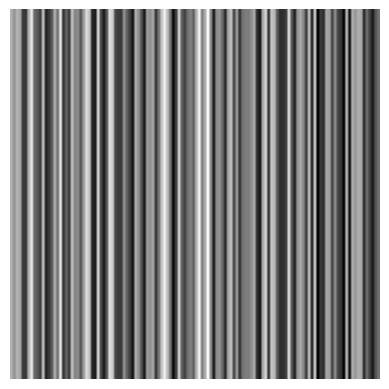

In [20]:
plt.imshow(time_emb.detach().cpu(),cmap = 'gray')
# plt.colorbar()
plt.axis(False)
plt.show()

In [21]:
# h = model.first(x)
# outs = [h]

In [23]:
# for layer in first_encoder:
#     h = layer(h,time_emb)
#     outs.append(h)

In [ ]:
# class Decoder_CAM(nn.Module):
#     def __init__(self,model,layer_k=6):
#         super().__init__()
#         self.unet = model
#         encoder    = model.encoder_blocks
#         bottleneck = model.bottleneck_blocks
#         decoder    = model.decoder_blocks
#         self.gradients = None
#         encoder_layer=decoder_layer=layer_k
#         bottle_layer=0
#         # self.first_encoder = encoder[:encoder_layer]
#         # self.second_encoder = encoder[encoder_layer:]

#         self.encoder_blocks   = encoder
#         self.bottleneck_blocks   = bottleneck
#         self.decoder_blocks   = decoder
#         # first_encoder = encoder[:encoder_layer]
#         # second_encoder = encoder[encoder_layer:]
#         # first_bottleneck = bottleneck[:bottle_layer]
#         # second_bottleneck = bottleneck[bottle_layer:]
#         self.first_decoder = decoder[:decoder_layer]
#         self.second_decoder = decoder[decoder_layer:]        
        
#         self.time_emb = None
#     def forward(self,x,ts):
#         # self.unet.eval()
#         time_emb= self.unet.time_embeddings(ts)
#         self.time_emb = time_emb
#         h = self.unet.first(x)
#         outs = [h]
#         for layer in self.first_encoder:
#             h = layer(h,time_emb)
#             outs.append(h)
            
#         for layer in self.second_encoder:
#             h = layer(h,time_emb)
#             outs.append(h)

#         for layer in self.bottleneck_blocks:
#             h = layer(h, time_emb)

#         for layer in self.decoder_blocks:
#             if isinstance(layer, ResnetBlock):
#                 out = outs.pop() # skip connection
#                 h = torch.cat([h, out], dim=1)
#             h = layer(h, time_emb)

#         h.register_hook(self.activations_hook)

#         h = self.unet.final(h)
#         return h
        
#     def activations_hook(self, grad):
#         self.gradients = grad
    
#     def get_activations_gradient(self):
#         # 목표로 하는 conv layer의 엑티베이션에 해당하는 gradient를 가져옴
#         return self.gradients
    
#     def get_activations(self, x):#forward부분
#         # time_emb= self.unet.time_embeddings(ts)
#         h = self.unet.first(x)
#         outs = [h]
#         for layer in self.first_encoder:
#             h = layer(h,self.time_emb)
#             outs.append(h)
#         return h

In [137]:
nn.Sequential(*list(model.decoder_blocks[-1:]))

Sequential(
  (0): ResnetBlock(
    (act_fn): SiLU()
    (normlize_1): GroupNorm(8, 128, eps=1e-05, affine=True)
    (conv_1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (dense_1): Linear(in_features=128, out_features=64, bias=True)
    (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (match_input): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (attention): Identity()
  )
)

In [92]:
class Decoder_CAM(nn.Module):
    def __init__(self,model,layer_k=-1):
        super().__init__()
        self.unet = model
        encoder    = model.encoder_blocks
        bottleneck = model.bottleneck_blocks
        decoder    = model.decoder_blocks
        self.gradients = None
        encoder_layer=decoder_layer=layer_k
        bottle_layer=0
        # self.first_encoder = encoder[:encoder_layer]
        # self.second_encoder = encoder[encoder_layer:]

        self.encoder_blocks   = encoder
        self.bottleneck_blocks   = bottleneck
        self.decoder_blocks   = decoder
        # first_encoder = encoder[:encoder_layer]
        # second_encoder = encoder[encoder_layer:]
        # first_bottleneck = bottleneck[:bottle_layer]
        # second_bottleneck = bottleneck[bottle_layer:]
        self.first_decoder = decoder[:-1]
        self.second_decoder = decoder[-1:]        
        
        self.time_emb = None
    def forward(self,x,ts):
        # self.unet.eval()
        self.time_emb = self.unet.time_embeddings(ts)
        h = self.unet.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, self.time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, self.time_emb)

        for layer in self.first_decoder:
            if isinstance(layer, ResnetBlock):
                out = outs.pop() # skip connection
                h = torch.cat([h, out], dim=1)
            h = layer(h, self.time_emb)
            
        h.register_hook(self.activations_hook)
        
        for layer in self.second_decoder:
            if isinstance(layer, ResnetBlock):
                out = outs.pop() # skip connection
                h = torch.cat([h, out], dim=1)
            h = layer(h, self.time_emb)
            
        h = self.unet.final(h)
        return h
        
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations_gradient(self):
        # 목표로 하는 conv layer의 엑티베이션에 해당하는 gradient를 가져옴
        return self.gradients
    
    def get_activations(self, x):#forward부분

        h = self.unet.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, self.time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, self.time_emb)

        for layer in self.first_decoder:
            if isinstance(layer, ResnetBlock):
                out = outs.pop() # skip connection
                h = torch.cat([h, out], dim=1)
            h = layer(h, self.time_emb)
        return h

In [93]:
cam = Decoder_CAM(model,layer_k=6)
cam.eval()
print()

In [94]:
output = cam(x_t,ts)

In [95]:
# predicted_noise = model(x_t,ts)
loss = F.mse_loss(noise, output)
loss.backward()

In [96]:
gradients = cam.get_activations_gradient()

In [97]:
alpha_k = torch.mean(gradients,dim =(0,2,3))

In [98]:
inverse_transform(alpha_k)

tensor([127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.5000,
        127.5000, 127.5000, 127.5000, 127.5000, 127.5000, 127.50

In [101]:
activations = cam.get_activations(x_t).detach()


In [102]:
for i in range(activations.size(1)):
    activations[:,i] = alpha_k[i]*activations[:,i]

In [103]:
activation_map = torch.mean(activations, dim=1).squeeze()

In [104]:
activation_map = F.relu(activation_map).to('cpu')
activation_map /= torch.max(activation_map)
activation_map = activation_map


In [105]:
def superimpose_heatmap(heatmap, img):
    # 색상 시각화 코드
    # The original code is written by François Chollet
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))
    resized_heatmap = np.uint8(255 * resized_heatmap)
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB)) * 0.006+ inv_norm(img[0]).permute(1,2,0)
    
    return superimposed_img

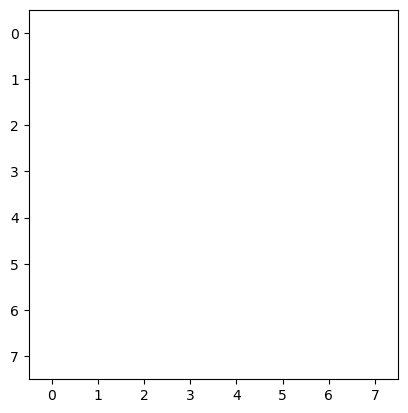

In [106]:
plt.imshow(activation_map[0],cmap ='gray')

In [55]:

# query = self.mhsa.in_proj_q(h)
# key = self.mhsa.in_proj_k(h)
# attn_scores = torch.bmm(query, key.transpose(1, 2))
# attn_scores = attn_scores / self.channels**0.5

NameError: name 'self' is not defined

In [49]:
a = cam.get_activations_gradient()

In [51]:
output.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
class Diffusion_CAM(nn.Modeul):
    def __init__(self,model,encoder_layer=6, decoder_layer=6 ,bottle_layer=0):
        super(Diffusion_CAM,self).__init__()
        self.diffusion = model
        encoder    = self.diffusion.encoder_blocks
        bottleneck = self.diffusion.bottleneck_blocks
        decoder    = self.diffusion.decoder_blocks
        
        self.first_encoder = encoder[:encoder_layer]
        self.second_encoder = encoder[encoder_layer:]
        
        self.first_bottleneck = bottleneck[:bottle_layer]
        self.second_bottleneck = bottleneck[bottle_layer:]
                
        self.first_decoder = decoder[:decoder_layer]
        self.second_decoder = decoder[decoder_layer:]
        
    def forward(self,x,t):
        

In [80]:
nn.Sequential(*list(model.children()))[:-1]

Sequential(
  (0): SinusoidalPositionEmbeddings(
    (time_blocks): Sequential(
      (0): Embedding(1000, 64)
      (1): Linear(in_features=64, out_features=128, bias=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (2): ModuleList(
    (0-1): 2 x ResnetBlock(
      (act_fn): SiLU()
      (normlize_1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (dense_1): Linear(in_features=128, out_features=64, bias=True)
      (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
      (dropout): Dropout2d(p=0.1, inplace=False)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (match_input): Identity()
      (attention): Identity()
    )
    (2): DownSample(
      (downsample): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): Resn

In [81]:
nn.Sequential(*list(model.children()))[-1]

Sequential(
  (0): GroupNorm(8, 64, eps=1e-05, affine=True)
  (1): SiLU()
  (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
)

In [78]:
model.decoder_blocks[-1]

ResnetBlock(
  (act_fn): SiLU()
  (normlize_1): GroupNorm(8, 128, eps=1e-05, affine=True)
  (conv_1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dense_1): Linear(in_features=128, out_features=64, bias=True)
  (normlize_2): GroupNorm(8, 64, eps=1e-05, affine=True)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (match_input): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (attention): Identity()
)

In [23]:
output = model(data.to(device),t )

In [73]:
model.encoder_blocks[6].attention

AttentionBlock(
  (group_norm): GroupNorm(8, 256, eps=1e-05, affine=True)
  (mhsa): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
)

In [ ]:
query = self.mhsa.in_proj_q(h)
key = self.mhsa.in_proj_k(h)
attn_scores = torch.bmm(query, key.transpose(1, 2))
attn_scores = attn_scores / self.channels**0.5

In [55]:
model.encoder_blocks[0].attention

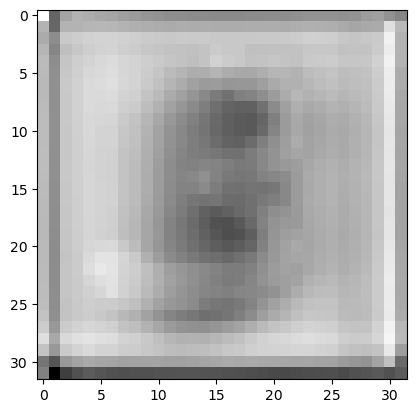

In [34]:
plt.imshow(output.detach().cpu()[].squeeze(),cmap='gray')
plt.show()

In [19]:
# noise_image,epsilon= diffusion.noise_images(data.to(config.device), t)

In [34]:
config.run_name

'DDPM_Uncondtional'

In [11]:
# def setup_logging(run_name):
#     os.makedirs("models", exist_ok=True)
#     os.makedirs("results", exist_ok=True)
#     os.makedirs(os.path.join("models", run_name), exist_ok=True)
#     os.makedirs(os.path.join("results", run_name), exist_ok=True)

In [12]:
setup_logging(config.run_name)

In [11]:
from torchmetrics import MeanMetric


In [14]:
loss_record = MeanMetric()

In [15]:
loss_record.update(1)

In [40]:

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cpu"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0) #alpha bar

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t): # forward
        sqrt_alpha_hat = torch.sqrt(get(self.alpha_hat[t])) # reshape(-1,1,1,1)
        sqrt_one_minus_alpha_hat = get(torch.sqrt(1 - self.alpha_hat[t]))# for broadcasting
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n,c_in = 3):
        # logging.info(f"Sampling {n} new images....")
        model.eval()
        x = torch.randn((n, c_in, self.img_size, self.img_size)).to(self.device)
        
        with torch.no_grad():
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0,total = self.noise_steps):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha     = get(self.alpha[t])
                alpha_hat = get(self.alpha_hat[t])
                beta      = get(self.beta[t])
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x
def get(value):
    return value[:,None,None,None]

In [46]:
diffusion = Diffusion(device ="cuda")

In [47]:
data, label = next(iter(train_loader))
# time_step = 999a
# num_images = 5
device = config.device
time_step =999
# diffusion  =ddpm.Diffusion(img_size=config.image_size,device = config.device)
ts = torch.ones(config.batch_size, dtype=torch.long, device=device) * time_step
x = torch.randn((config.batch_size, 1, config.image_size,config.image_size)).to(device)
# alpha = diffusion.alpha[ts][:, None, None, None]
# alpha_hat = diffusion.alpha_hat[ts][:, None, None, None]
# beta = diffusion.beta[ts][:, None, None, None]
# noise = torch.zeros_like(x)
#sampling
# predicted_noise = model(x,ts)
# x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

In [51]:
image,noise = diffusion.noise_images(x,ts)

In [ ]:
diffusion = Diffusion()

In [29]:
diffusion.prepare_noise_schedule()

tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
        2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04, 2.9920e-04, 3.1912e-04,
        3.3904e-04, 3.5896e-04, 3.7888e-04, 3.9880e-04, 4.1872e-04, 4.3864e-04,
        4.5856e-04, 4.7848e-04, 4.9840e-04, 5.1832e-04, 5.3824e-04, 5.5816e-04,
        5.7808e-04, 5.9800e-04, 6.1792e-04, 6.3784e-04, 6.5776e-04, 6.7768e-04,
        6.9760e-04, 7.1752e-04, 7.3744e-04, 7.5736e-04, 7.7728e-04, 7.9720e-04,
        8.1712e-04, 8.3704e-04, 8.5696e-04, 8.7688e-04, 8.9680e-04, 9.1672e-04,
        9.3664e-04, 9.5656e-04, 9.7648e-04, 9.9640e-04, 1.0163e-03, 1.0362e-03,
        1.0562e-03, 1.0761e-03, 1.0960e-03, 1.1159e-03, 1.1358e-03, 1.1558e-03,
        1.1757e-03, 1.1956e-03, 1.2155e-03, 1.2354e-03, 1.2554e-03, 1.2753e-03,
        1.2952e-03, 1.3151e-03, 1.3350e-03, 1.3550e-03, 1.3749e-03, 1.3948e-03,
        1.4147e-03, 1.4346e-03, 1.4546e-03, 1.4745e-03, 1.4944e-03, 1.5143e-03,
        1.5342e-03, 1.5542e-03, 1.5741e-

In [25]:
DD = SimpleDiffusion()

In [28]:
DD.beta

tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
        2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04, 2.9920e-04, 3.1912e-04,
        3.3904e-04, 3.5896e-04, 3.7888e-04, 3.9880e-04, 4.1872e-04, 4.3864e-04,
        4.5856e-04, 4.7848e-04, 4.9840e-04, 5.1832e-04, 5.3824e-04, 5.5816e-04,
        5.7808e-04, 5.9800e-04, 6.1792e-04, 6.3784e-04, 6.5776e-04, 6.7768e-04,
        6.9760e-04, 7.1752e-04, 7.3744e-04, 7.5736e-04, 7.7728e-04, 7.9720e-04,
        8.1712e-04, 8.3704e-04, 8.5696e-04, 8.7688e-04, 8.9680e-04, 9.1672e-04,
        9.3664e-04, 9.5656e-04, 9.7648e-04, 9.9640e-04, 1.0163e-03, 1.0362e-03,
        1.0562e-03, 1.0761e-03, 1.0960e-03, 1.1159e-03, 1.1358e-03, 1.1558e-03,
        1.1757e-03, 1.1956e-03, 1.2155e-03, 1.2354e-03, 1.2554e-03, 1.2753e-03,
        1.2952e-03, 1.3151e-03, 1.3350e-03, 1.3550e-03, 1.3749e-03, 1.3948e-03,
        1.4147e-03, 1.4346e-03, 1.4546e-03, 1.4745e-03, 1.4944e-03, 1.5143e-03,
        1.5342e-03, 1.5542e-03, 1.5741e-

In [24]:
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000, #  T = 1000
        img_shape=(3, 64, 64),        # default is RGB
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta
        
        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
         
    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps # 1
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )
        
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    mean    = get(sd.sqrt_alpha_cumulative, t=timesteps) * x0  # Image scaled
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise

    return sample, eps  # return ... , gt noise --> model predicts this)

In [11]:
# def train(args):
# setup_logging(args.run_name)
device = config.device
# dataloader = get_data(args)
# model = UNet().to(device)
scaler = amp.GradScaler() # cuda 

model = UNet(input_channels=1,output_channels=1)
model.to(config.device)
optimizer = optim.AdamW(model.parameters(), lr=config.lr)
mse = nn.MSELoss()
diffusion  =ddpm.Diffusion(img_size=config.image_size,device = config.device)
# diffusion = Diffusion(img_size=config.image_size, device=device)
# logger = SummaryWriter(os.path.join("runs", args.run_name))
l = len(train_loader)
loss_list = []
for epoch in range(config.epochs):
    torch.cuda.empty_cache()
    # logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(train_loader)
    for i, (images, _) in enumerate(pbar):
        images = images.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        
        with amp.autocast():
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        # loss.backward()
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()

        pbar.set_postfix(MSE=loss.item())
        loss_list.append(loss.item())
        # logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
        pbar.set_description("Processing batch %d" %i)
        
    sampled_images = diffusion.sample(model, n=images.shape[0])
    save_images(sampled_images, os.path.join("results", config.run_name, f"{epoch}.jpg"))
    torch.save(model.state_dict(), os.path.join("models", config.run_name, f"ckpt.pt"))

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 